# Feature Selection/Reduction (PCA - Principal component analysis) 

Principal Component Analysis (PCA) is a dimensionality reduction technique used in statistics and machine learning. Its primary goal is to transform a high-dimensional dataset into a new coordinate system while preserving the most important information and reducing the data's complexity. PCA achieves this by creating new variables, called principal components, which are linear combinations of the original features.

## Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score

In [2]:
# Loading dataset
full_df = pd.read_csv('full_df.csv')
full_df.shape

(9823, 3511)

In [3]:
# Removing every row without target
full_df.dropna(subset=["TARGET_BINARY"], inplace=True)
full_df.shape

(2897, 3511)

In [4]:
full_df.head(5)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,PAXVMD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXMTSD,PAXLXSD,DXXNK_TSCORE,CLASSES,TARGET_BINARY
1,73558.0,8.0,2.0,1.0,54.0,NaN,3.0,3.0,1.0,NaN,...,1406.954723,751.055960,428.131182,161.938053,65.821707,10419.291313,81496.392640,-0.358333,normal,0.0
4,73561.0,8.0,2.0,2.0,73.0,NaN,3.0,3.0,1.0,NaN,...,1350.100703,732.742842,523.622853,15.277460,78.630141,7292.593313,77089.786076,-1.133333,osteopenia,1.0
5,73562.0,8.0,2.0,1.0,56.0,NaN,1.0,1.0,1.0,NaN,...,1367.985168,893.758010,411.697577,0.000000,62.457671,16144.391078,22463.894999,0.316667,normal,0.0
7,73564.0,8.0,2.0,2.0,61.0,NaN,3.0,3.0,2.0,NaN,...,1350.280250,740.180848,537.204007,14.680978,58.214416,10725.330844,178102.984201,-0.433333,normal,0.0
9,73566.0,8.0,2.0,2.0,56.0,NaN,3.0,3.0,1.0,NaN,...,1406.954723,840.501822,495.787611,37.763925,32.893545,18438.607753,32274.947265,-1.675000,osteopenia,1.0


## Data Preprocessing

### Feature Selection/Engineering

PCA is a technique designed to work with continuous numerical features. The mathematical foundations and computations involved in PCA are based on concepts like means, variances, and covariance matrices, which are applicable to continuous variables.
This is why categorical features need to be handled or transformed before applying PCA, therefore in the following cell we are removing every feature that is categorical.

In [5]:
non_numeric_columns = full_df.select_dtypes(exclude=['float64', 'int64']).columns
full_df[non_numeric_columns].head(5)

,CSXTSEQ,OHX02CTC,OHX03CTC,OHX04CTC,OHX05CTC,OHX06CTC,OHX07CTC,OHX08CTC,OHX09CTC,OHX10CTC,...,OHX19SE,OHX20SE,OHX21SE,OHX28SE,OHX29SE,OHX30SE,OHX31SE,SMDUPCA,SMD100BR,CLASSES
1,b'A',b'Z',b'J',b'S',b'S',b'S',b'S',b'S',b'S',b'S',...,b'',b'',b'',b'',b'',b'',b'',b'',b'',normal
4,b'A',b'E',b'Z',b'E',b'Z',b'Z',b'Z',b'R',b'R',b'Z',...,b'',b'',b'',b'',b'',b'',b'',b'',b'',osteopenia
5,b'B',b'Z',b'Z',b'R',b'Z',b'R',b'R',b'Y',b'Y',b'Y',...,b'',b'',b'',b'',b'',b'',b'',b'',b'',normal
7,b'A',b'Z',b'Z',b'Z',b'Z',b'S',b'S',b'S',b'S',b'S',...,b'',b'',b'',b'',b'',b'',b'',b'',b'',normal
9,b'B',b'Z',b'Z',b'S',b'M',b'S',b'Z',b'Z',b'Z',b'Z',...,b'',b'',b'',b'',b'',b'',b'',b'027200001859',b'PALL MALL ORANGE',osteopenia


In [6]:
numeric_df = full_df.drop(columns=non_numeric_columns)
numeric_df.shape

(2897, 3433)

Now, we have removed the non-categorical features that are not represent with numeric values. However, we can still have features that are categorical but were encoded in numerical values. unfortunately, there is no way of knowing which features are categorical and represented in a numeric way, without going through them one by one. That process is not practical considering we are left with 3433 features in the numeric dataframe from the cell above.
With that, one way of finding potential categorical features is to check the unique values of each feature and discarding them if they are very low considering the number of rows.

In [7]:
class NumericCategoricalFeaturesCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_unique_values=10):
        self.threshold_unique_values = threshold_unique_values
    
    def fit(self, X, y=None):
        self.potential_encoded_features_ = []
        self.unique_count_per_feature_ = {}
        
        for column in X.columns:
            unique_count = len(X[column].unique())
            self.unique_count_per_feature_[column] = unique_count
            if unique_count <= self.threshold_unique_values:
                self.potential_encoded_features_.append(column)
        
        # Remove 'TARGET_BINARY' from potential_encoded_features
        if 'TARGET_BINARY' in self.potential_encoded_features_:
            self.potential_encoded_features_.remove('TARGET_BINARY')
        
        return self
    
    def transform(self, X):
        # Drop selected features from the DataFrame and return remaining continuous features
        self.continuous_df_ = X.drop(columns=self.potential_encoded_features_)
        return self.continuous_df_

In [8]:
# Create the FeatureSelector transformer
feature_selector = NumericCategoricalFeaturesCleaner(threshold_unique_values=10)

# Fit the FeatureSelector on your data
feature_selector.fit(numeric_df)

# Transform the data to select relevant features
continuous_df = feature_selector.transform(numeric_df)
continuous_df

,SEQN,RIDAGEYR,DMDHRAGE,WTINT2YR,WTMEC2YR,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1_x,...,PAXSUMVVPA,PAXVMD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXMTSD,PAXLXSD,DXXNK_TSCORE,TARGET_BINARY
1,73558.0,54.0,54.0,23682.057386,24471.769625,108.0,7.0,7.0,1.78,17932.143865,...,105.779040,1406.954723,751.055960,428.131182,161.938053,65.821707,10419.291313,81496.392640,-0.358333,0.0
4,73561.0,73.0,78.0,63709.667069,65541.871229,116.0,15.0,15.0,5.00,59052.357033,...,0.000000,1350.100703,732.742842,523.622853,15.277460,78.630141,7292.593313,77089.786076,-1.133333,1.0
5,73562.0,56.0,56.0,24978.144602,25344.992359,111.0,9.0,9.0,4.79,49890.828664,...,642.771324,1367.985168,893.758010,411.697577,0.000000,62.457671,16144.391078,22463.894999,0.316667,0.0
7,73564.0,61.0,61.0,60325.095254,61758.654880,114.0,10.0,10.0,5.00,78988.755072,...,65.962823,1350.280250,740.180848,537.204007,14.680978,58.214416,10725.330844,178102.984201,-0.433333,0.0
9,73566.0,56.0,56.0,16351.783140,17480.115175,112.0,4.0,4.0,0.48,30697.880780,...,674.261463,1406.954723,840.501822,495.787611,37.763925,32.893545,18438.607753,32274.947265,-1.675000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,83718.0,60.0,60.0,34902.817661,37866.383266,113.0,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.608333,1.0
9813,83721.0,52.0,47.0,67937.153461,68456.771849,112.0,15.0,15.0,5.00,50162.971463,...,61.071038,1406.954723,636.379750,181.087454,566.129360,23.350338,9792.238396,110640.225606,-0.266667,0.0
9815,83723.0,61.0,61.0,11140.687817,11179.994842,109.0,10.0,10.0,3.53,14116.878928,...,31.422507,1348.781421,789.593644,368.377963,127.859338,62.860120,11455.101360,658520.293527,1.191667,0.0
9817,83726.0,40.0,43.0,45268.572702,49177.291000,115.0,9.0,9.0,3.81,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.841667,0.0


### Data Cleaning

Now that we have handled the categorical features, we need to handle the missing values to perform the PCA.

In [9]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10, fill_method=2):
        self.threshold = threshold
        self.fill_method = fill_method
    
    def fit(self, X, y=None):
        # Calculate missing percentage for each feature
        self.missing_percentage_ = (X.isna().sum() / len(X)) * 100
        
        # Find features to drop based on the threshold
        self.features_to_drop_ = self.missing_percentage_[self.missing_percentage_ > self.threshold].index.tolist()
        
        # Calculate fill value based on fill_method
        if self.fill_method == 1:
            self.fill_value_ = X.mean()
        elif self.fill_method == 2:
            self.fill_value_ = X.median()
        
        return self
    
    def transform(self, X):
        # Drop features with missing values exceeding the threshold
        cleaned_X = X.drop(columns=self.features_to_drop_)
        
        # Fill missing values with the calculated fill value
        if self.fill_method != 0:
            cleaned_X = cleaned_X.fillna(self.fill_value_)
        
        return cleaned_X

In [10]:
# Create the DataCleaner transformer
data_cleaner = DataCleaner(threshold=10, fill_method=2)

# Fit the DataCleaner on your data
data_cleaner.fit(continuous_df)

# Transform the data to apply data cleaning
cleaned_df = data_cleaner.transform(continuous_df)

# Print the shape before and after cleaning
print(f'Shape before cleaning: {continuous_df.shape}')
print(f'Shape after cleaning: {cleaned_df.shape}')
print(f'Dropped features: {len(data_cleaner.features_to_drop_)}')


Shape before cleaning: (2897, 1316)
Shape after cleaning: (2897, 241)
Dropped features: 1075


In [11]:
data_cleaner.missing_percentage_.sort_values(ascending=False)

DSQTCAFF         99.620297
MCQ240N          99.585778
MCQ240CC         99.551260
PHAALCMN         99.516741
OSD110C          99.482223
                   ...    
WTDRD1_x          0.000000
SDMVSTRA          0.000000
WTMEC2YR          0.000000
WTINT2YR          0.000000
TARGET_BINARY     0.000000
Length: 1316, dtype: float64

In [12]:
cleaned_df['WTMEC2YR']

1       24471.769625
4       65541.871229
5       25344.992359
7       61758.654880
9       17480.115175
            ...     
9810    37866.383266
9813    68456.771849
9815    11179.994842
9817    49177.291000
9820    26902.344381
Name: WTMEC2YR, Length: 2897, dtype: float64

In [13]:
cleaned_df.isna().sum().sort_values(ascending=False)

SEQN             0
MGXH2T2          0
LBXSKSI          0
LBXSLDSI         0
LBXSNASI         0
                ..
WTDR2D_x.1       0
DR1EXMER_y       0
DR1DBIH_y        0
DS1DSCNT         0
TARGET_BINARY    0
Length: 241, dtype: int64

Removing the "SEQN" feature, which is the ID, and removing the "TARGET_BINARY" and "DXXNK_TSCORE" which are related to the target so it is a must to remove them before performing the PCA.

In [14]:
class ExtractTargetFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        target = X["TARGET_BINARY"]
        target.reset_index(drop=True, inplace=True)
        features = X.drop(columns=["TARGET_BINARY", "SEQN", "DXXNK_TSCORE"])
        return features, target

In [15]:
# Create the ExtractTargetFeatures transformer
extractor = ExtractTargetFeatures()

# Fit the extractor on your data
extractor.fit(cleaned_df)

# Transform the data to extract the target and features
df, target = extractor.transform(cleaned_df)

# Print the extracted features target
print("Features:")
print(df.shape)
print("Target:")
print(target.shape)

df

Features:
(2897, 238)
Target:
(2897,)


,RIDAGEYR,DMDHRAGE,WTINT2YR,WTMEC2YR,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1_x,WTDR2D_x,...,HOD050,PAD680,SLD010H,WHD010,WHD020,WHD050,WHD110,WHD120,WHD140,WHQ150
1,54.0,54.0,23682.057386,24471.769625,108.0,7.0,7.0,1.780,17932.143865,12684.148869,...,7.0,540.0,9.0,71.0,200.0,160.0,240.0,250.0,250.0,25.0
4,73.0,78.0,63709.667069,65541.871229,116.0,15.0,15.0,5.000,59052.357033,39004.892993,...,8.0,480.0,9.0,67.0,120.0,150.0,150.0,135.0,170.0,60.0
5,56.0,56.0,24978.144602,25344.992359,111.0,9.0,9.0,4.790,49890.828664,0.000000,...,6.0,360.0,5.0,64.0,235.0,240.0,225.0,195.0,244.0,54.0
7,61.0,61.0,60325.095254,61758.654880,114.0,10.0,10.0,5.000,78988.755072,52173.157754,...,6.0,60.0,9.0,64.0,212.0,212.0,195.0,127.0,212.0,61.0
9,56.0,56.0,16351.783140,17480.115175,112.0,4.0,4.0,0.480,30697.880780,0.000000,...,5.0,30.0,6.0,61.0,137.0,137.0,130.0,120.0,152.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,60.0,60.0,34902.817661,37866.383266,113.0,8.0,8.0,2.365,0.000000,25387.752643,...,6.0,720.0,4.0,66.0,165.0,208.0,270.0,120.0,280.0,50.0
9813,52.0,47.0,67937.153461,68456.771849,112.0,15.0,15.0,5.000,50162.971463,35482.349602,...,5.0,240.0,8.0,70.0,172.0,172.0,172.0,163.0,181.0,45.0
9815,61.0,61.0,11140.687817,11179.994842,109.0,10.0,10.0,3.530,14116.878928,9661.836186,...,5.0,360.0,6.0,69.0,220.0,245.0,240.0,200.0,245.0,61.0
9817,40.0,43.0,45268.572702,49177.291000,115.0,9.0,9.0,3.810,0.000000,25387.752643,...,4.0,360.0,8.0,66.0,180.0,170.0,160.0,160.0,180.0,40.0


## Scaling/Normalization

To extract better results from PCA, StandardScaler is used to standardize the data.

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_features, columns=df.columns)
scaled_df.shape

(2897, 238)

# Performing PCA

In [17]:
#Defining the number of principal components to generate 
n_features = scaled_df.shape[1]
print(f'Number of features: {n_features}')

#Finding principal components for the data
pca = PCA(n_components=n_features, random_state=1)
data_pca1 = pd.DataFrame(pca.fit_transform(scaled_df))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

Number of features: 238


## Explained Variance


Explained Variance is a fundamental metric that helps us understand how much of the total variance in the original dataset is captured by each principal component.

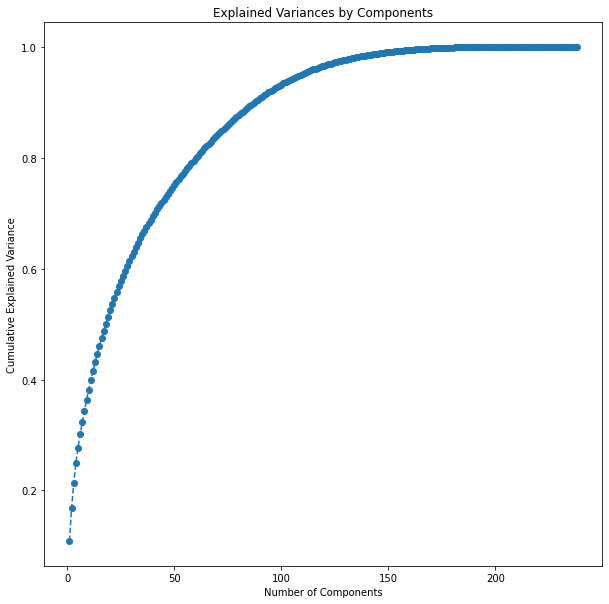

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
plt.plot(range(1,n_features+1), exp_var.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [19]:
# Initialize variables to keep track of cumulative explained variance and the number of components above 90% variance
sum = 0  # Cumulative explained variance
n_components_above_90 = 0  # Number of components above 90% variance

# Loop through the explained variance values (exp_var) and their indices (ix)
for ix, i in enumerate(exp_var):
    # Add the current explained variance value to the cumulative sum
    sum = sum + i

    # Check if the cumulative explained variance has exceeded 90%
    if sum > 0.90:
        # Record the number of principal components required to explain at least 90% variance
        n_components_above_90 = ix + 1
        print(f'Number of PCs that explain at least 90% variance: {ix + 1}')
        break

Number of PCs that explain at least 90% variance: 88


In [20]:
# Calculate the gap size as 10% of the total number of features
gap_size = round(n_features * 0.1)

# Create a list of candidate values for the number of principal components
n_components_list = list(range(gap_size, n_features, gap_size))

# Append the number of components needed to explain at least 90% variance
n_components_list.append(n_components_above_90)

# Sort the list of candidate values in ascending order
n_components_list.sort()

# The resulting n_components_list contains candidate values for the number of principal components
# These values are spaced apart by 10% of the total number of features and include the number of components needed for 90% variance


## PCA Feature Loadings

Feature Loading is a concept that helps us understand the relationship between the original features and the principal components (PCs). It provides insights into how each feature contributes to the formation of principal components.

In [21]:
def PlotFeatureLoadings(n):
    pca = PCA(n_components=n)
    pca.fit_transform(scaled_df)
    
    # Access the loadings (coefficients) for the original features in each principal component
    loadings = pca.components_

    # Create a DataFrame to show the loadings for each feature in each principal component
    loadings_df = pd.DataFrame(loadings, columns=df.columns)

    first_component_loadings = loadings_df.iloc[0]

    # Sort loadings for visualization
    n_features_to_display = round(loadings_df.shape[0]/5)
    sorted_loadings = first_component_loadings.abs().sort_values(ascending=False)[:n_features_to_display]

    # Plot bar chart of loadings
    plt.figure(figsize=(30, 10))
    plt.bar(sorted_loadings.index, sorted_loadings)
    plt.xticks(rotation=90)
    plt.ylabel('Loading Value')
    plt.xlabel(f'The {n_features_to_display} most influencial features')
    plt.title('Loadings of First Principal Component')
    plt.show()

    print(f'Most influencial feature: {sorted_loadings.index[0]}')

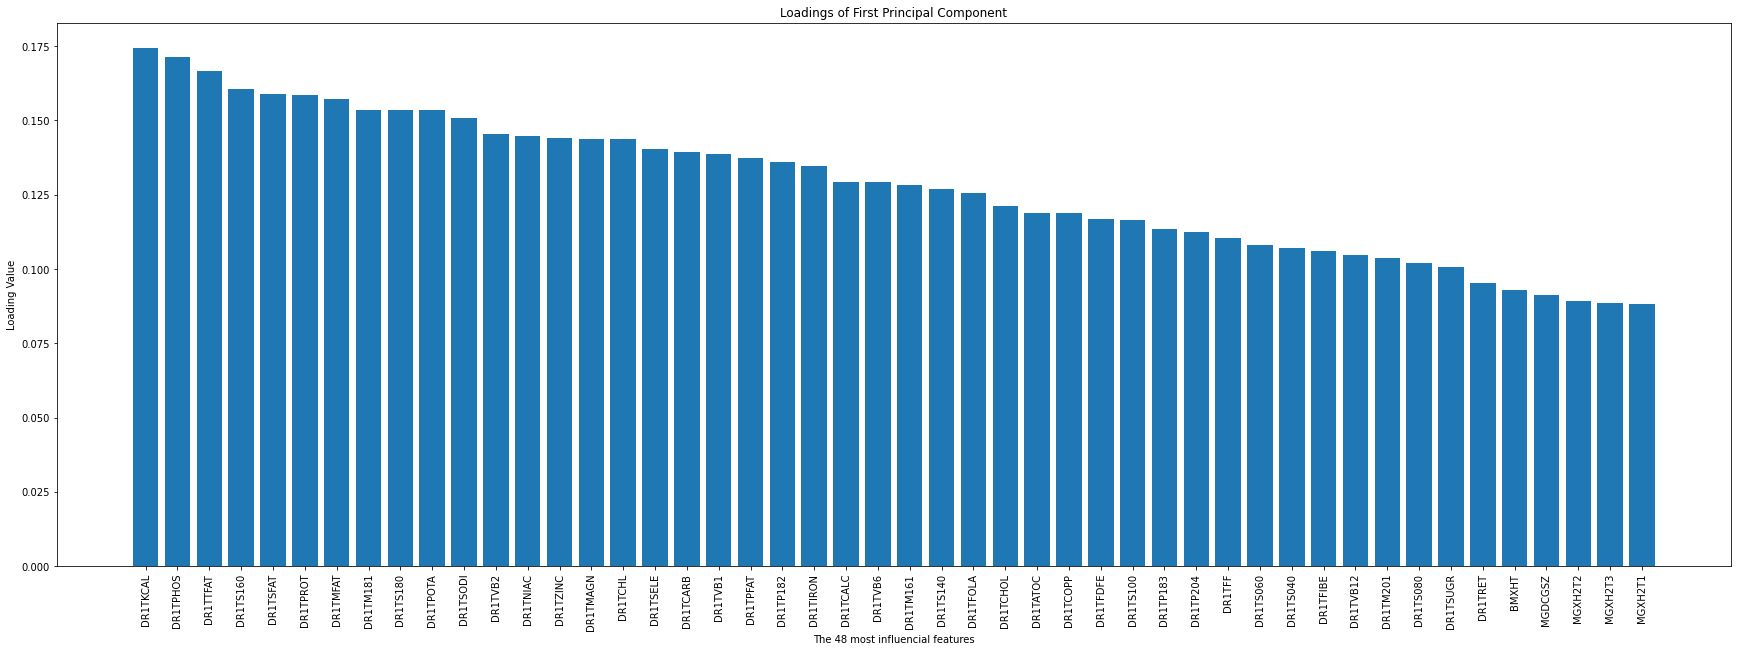

Most influencial feature: DR1TKCAL


In [22]:
PlotFeatureLoadings(n_features)

In [23]:
# Create an empty list to store DataFrames containing PCA results
pca_result_df_list = []

# Loop over different numbers of principal components specified in n_components_list
for i in n_components_list:
    # Create a PCA (Principal Component Analysis) object with the desired number of components
    pca = PCA(n_components=i)

    # Fit the PCA model and transform the scaled data into a reduced-dimensional space
    pca_result = pca.fit_transform(scaled_df)

    # Convert the PCA results into a DataFrame and append it to the list
    pca_result_df_list.append(pd.DataFrame(pca_result))

    # Print the number of principal components obtained after dimensionality reduction
    print(f'Number of principal components: {pd.DataFrame(pca_result).shape[1]}')


Number of principal components: 24
Number of principal components: 48
Number of principal components: 72
Number of principal components: 88
Number of principal components: 96
Number of principal components: 120
Number of principal components: 144
Number of principal components: 168
Number of principal components: 192
Number of principal components: 216


In [24]:
def metrics_score(actual, predicted):
    report = classification_report(actual, predicted, output_dict=True)
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Normal', 'Osteo'], yticklabels=['Normal', 'Osteo'], cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return report

## Data Splitting and Model Training

Number of principal components: 24

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      1247
         1.0       0.67      0.59      0.63       780

    accuracy                           0.73      2027
   macro avg       0.72      0.70      0.71      2027
weighted avg       0.73      0.73      0.73      2027



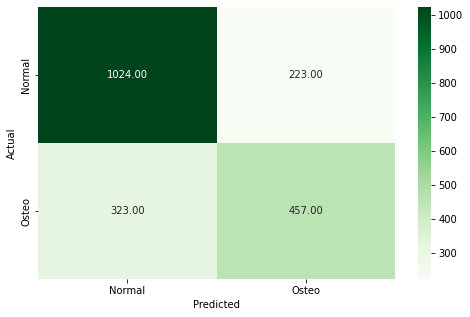

TEST SET
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       530
         1.0       0.67      0.54      0.60       340

    accuracy                           0.72       870
   macro avg       0.71      0.69      0.69       870
weighted avg       0.71      0.72      0.71       870



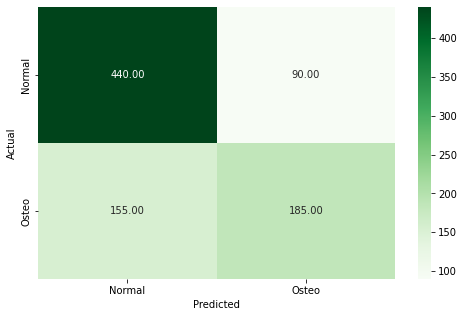

--------------------------------------------------------------
Number of principal components: 48

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80      1247
         1.0       0.70      0.60      0.65       780

    accuracy                           0.75      2027
   macro avg       0.73      0.72      0.72      2027
weighted avg       0.74      0.75      0.74      2027



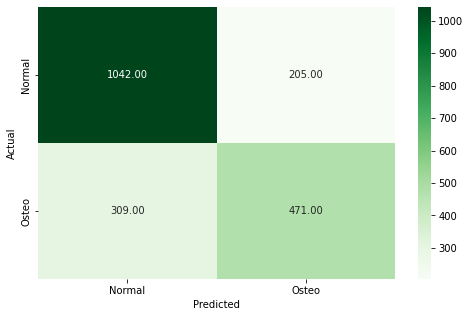

TEST SET
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       530
         1.0       0.66      0.53      0.58       340

    accuracy                           0.71       870
   macro avg       0.69      0.67      0.68       870
weighted avg       0.70      0.71      0.70       870



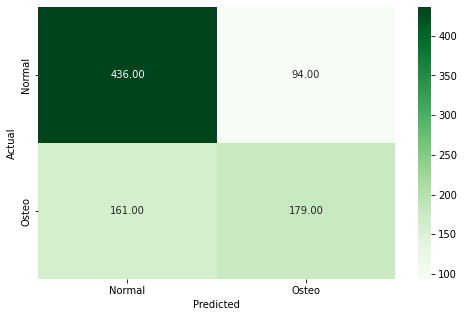

--------------------------------------------------------------
Number of principal components: 72

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81      1247
         1.0       0.71      0.64      0.67       780

    accuracy                           0.76      2027
   macro avg       0.75      0.74      0.74      2027
weighted avg       0.76      0.76      0.76      2027



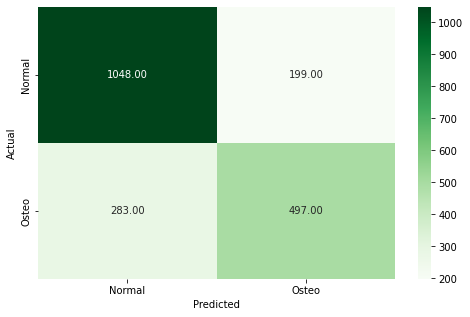

TEST SET
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       530
         1.0       0.67      0.57      0.61       340

    accuracy                           0.72       870
   macro avg       0.71      0.69      0.70       870
weighted avg       0.72      0.72      0.72       870



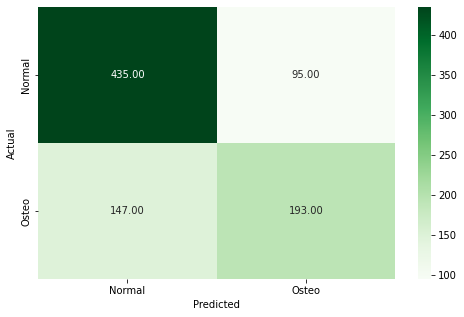

--------------------------------------------------------------
Number of principal components: 88

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      1247
         1.0       0.71      0.62      0.67       780

    accuracy                           0.76      2027
   macro avg       0.75      0.73      0.74      2027
weighted avg       0.76      0.76      0.76      2027



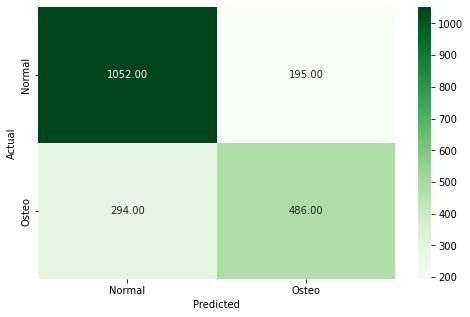

TEST SET
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       530
         1.0       0.66      0.56      0.61       340

    accuracy                           0.72       870
   macro avg       0.70      0.69      0.69       870
weighted avg       0.71      0.72      0.71       870



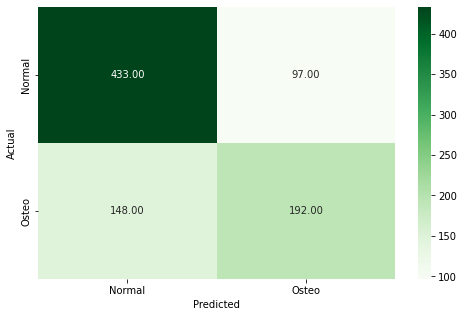

--------------------------------------------------------------
Number of principal components: 96

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      1247
         1.0       0.71      0.63      0.67       780

    accuracy                           0.76      2027
   macro avg       0.74      0.73      0.74      2027
weighted avg       0.75      0.76      0.75      2027



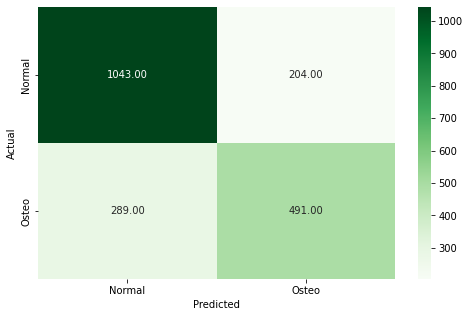

TEST SET
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       530
         1.0       0.65      0.58      0.61       340

    accuracy                           0.71       870
   macro avg       0.70      0.69      0.69       870
weighted avg       0.71      0.71      0.71       870



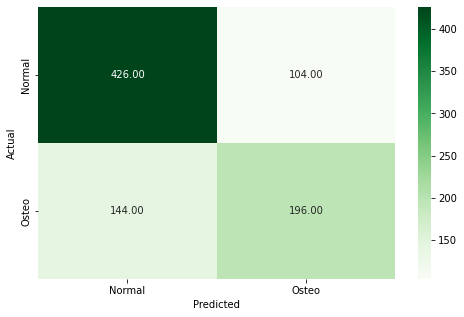

--------------------------------------------------------------
Number of principal components: 120

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      1247
         1.0       0.73      0.64      0.68       780

    accuracy                           0.77      2027
   macro avg       0.76      0.74      0.75      2027
weighted avg       0.77      0.77      0.76      2027



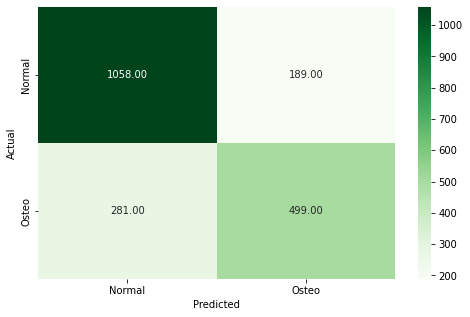

TEST SET
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       530
         1.0       0.65      0.55      0.59       340

    accuracy                           0.71       870
   macro avg       0.69      0.68      0.68       870
weighted avg       0.70      0.71      0.70       870



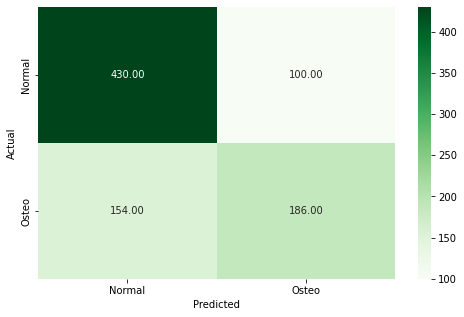

--------------------------------------------------------------
Number of principal components: 144

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      1247
         1.0       0.73      0.65      0.69       780

    accuracy                           0.77      2027
   macro avg       0.76      0.75      0.75      2027
weighted avg       0.77      0.77      0.77      2027



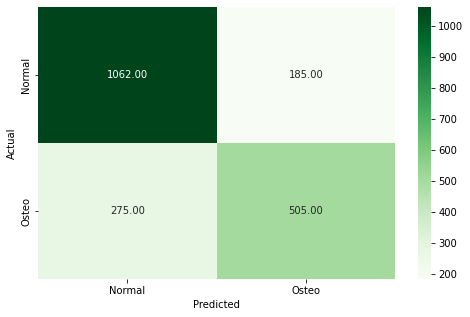

TEST SET
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       530
         1.0       0.66      0.57      0.61       340

    accuracy                           0.72       870
   macro avg       0.70      0.69      0.69       870
weighted avg       0.71      0.72      0.71       870



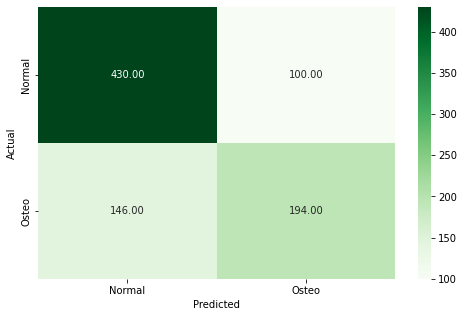

--------------------------------------------------------------
Number of principal components: 168

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      1247
         1.0       0.73      0.65      0.69       780

    accuracy                           0.77      2027
   macro avg       0.76      0.75      0.75      2027
weighted avg       0.77      0.77      0.77      2027



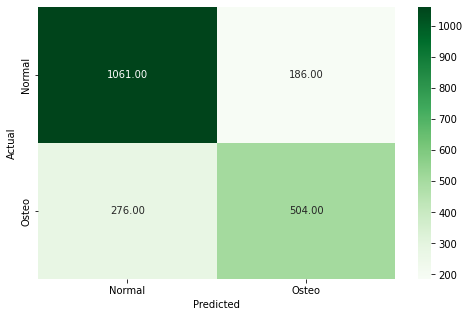

TEST SET
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       530
         1.0       0.64      0.57      0.60       340

    accuracy                           0.71       870
   macro avg       0.69      0.68      0.69       870
weighted avg       0.70      0.71      0.70       870



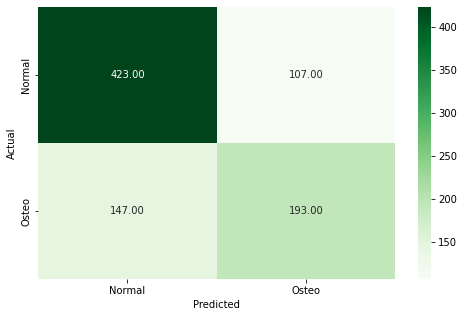

--------------------------------------------------------------
Number of principal components: 192

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      1247
         1.0       0.75      0.66      0.70       780

    accuracy                           0.78      2027
   macro avg       0.77      0.76      0.76      2027
weighted avg       0.78      0.78      0.78      2027



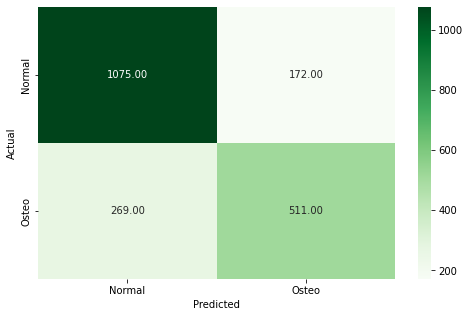

TEST SET
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       530
         1.0       0.64      0.56      0.60       340

    accuracy                           0.70       870
   macro avg       0.69      0.68      0.68       870
weighted avg       0.70      0.70      0.70       870



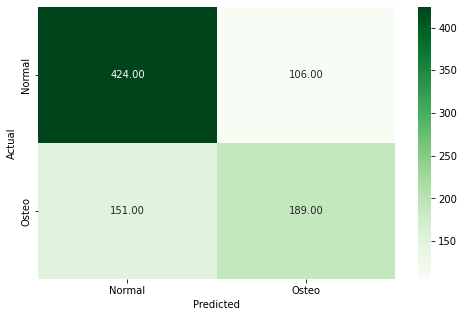

--------------------------------------------------------------
Number of principal components: 216

TRAIN SET
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      1247
         1.0       0.75      0.65      0.70       780

    accuracy                           0.78      2027
   macro avg       0.78      0.76      0.77      2027
weighted avg       0.78      0.78      0.78      2027



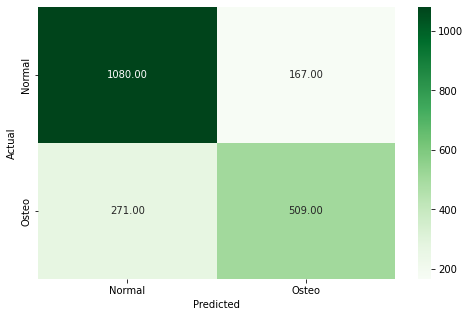

TEST SET
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76       530
         1.0       0.63      0.56      0.59       340

    accuracy                           0.70       870
   macro avg       0.68      0.67      0.68       870
weighted avg       0.69      0.70      0.69       870



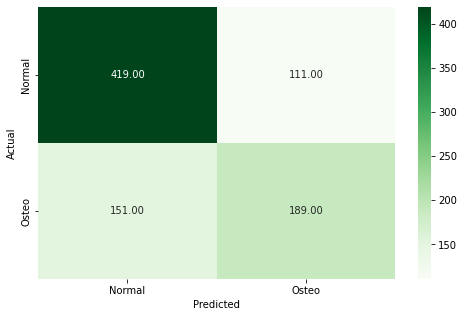

--------------------------------------------------------------


In [25]:
logistic=LogisticRegression(max_iter=300, random_state=42)

metrics_score_list = []
roc_auc_score_list = []
metrics_score_list2 = []
roc_auc_score_list2 = []
for i in pca_result_df_list:
    print(f'Number of principal components: {len(i.columns)}\n')
    X_train, X_test, y_train, y_test = train_test_split(i, target, test_size=0.3, random_state=42)
    logistic.fit(X=X_train,y=y_train)
    logistic.predict(X_test)
    #print(f'Accuracy: {logistic.score(X_test,y_test)}')
    print("TRAIN SET")
    metrics_score_list.append(metrics_score(y_train, logistic.predict(X_train)))
    roc_auc_score_list.append(roc_auc_score(y_train, logistic.predict(X_train)))
    print("TEST SET")
    metrics_score_list2.append(metrics_score(y_test, logistic.predict(X_test)))
    roc_auc_score_list2.append(roc_auc_score(y_test, logistic.predict(X_test)))
    #print(roc_auc_score(y_test, logistic.predict(X_test)))
    print(f'--------------------------------------------------------------')
    

## Metrics Visualization

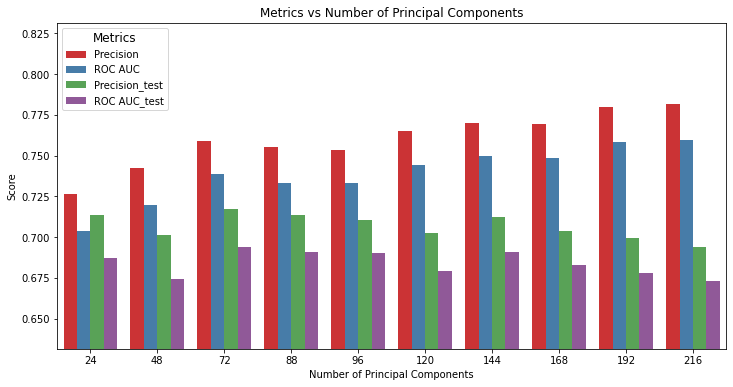

In [26]:
precision_score_list = []
precision_score_list2 = []

for i in metrics_score_list:
    precision_score_list.append(i['weighted avg']['precision'])

for i in metrics_score_list2:
    precision_score_list2.append(i['weighted avg']['precision'])

# Create a DataFrame
data = {
    'Number of Principal Components': n_components_list,
    'Precision': precision_score_list,
    'ROC AUC': roc_auc_score_list,
    'Precision_test': precision_score_list2,
    'ROC AUC_test': roc_auc_score_list2
}

df = pd.DataFrame(data)

# Melt the DataFrame to reshape it into a "tidy" format
df_melted = pd.melt(df, id_vars=['Number of Principal Components'], value_vars=['Precision', 'ROC AUC', 'Precision_test', 'ROC AUC_test'], var_name='Metrics', value_name='Score')

# Set up the figure
plt.figure(figsize=(12, 6))

# Create a grouped bar plot using seaborn
sns.barplot(x='Number of Principal Components', y='Score', hue='Metrics', data=df_melted, palette='Set1')

plt.title('Metrics vs Number of Principal Components')
plt.ylim(0, 1.0)  # Set the y-axis limits for better visualization
plt.ylim(max(max(max(precision_score_list), max(roc_auc_score_list)) - 0.15, 0), min(max(max(precision_score_list), max(roc_auc_score_list)) + 0.05, 1))  # Set the y-axis limits for better visualization
plt.legend(title='Metrics', title_fontsize='12')
plt.show()


# Hyperparameter Tuning

In this Hyperparameter tuning section, the dataset with 88 principal components is choosen as it is the one with the least features that explains 90% of the original data.

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_result_df_list[3], target, test_size=0.3, random_state=42)

# Create a logistic regression model
logistic = LogisticRegression()

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'solver': ['lbfgs', 'liblinear'],  # Solver algorithm
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Create the grid search with cross-validation
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)

# Create a logistic regression model with the best hyperparameters
best_logistic = LogisticRegression(**best_params)

# Fit the best model to the training data
best_logistic.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_logistic.predict(X_test)

{'C': 0.001, 'max_iter': 100, 'solver': 'lbfgs'}


              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       530
         1.0       0.71      0.51      0.60       340

    accuracy                           0.73       870
   macro avg       0.72      0.69      0.69       870
weighted avg       0.72      0.73      0.72       870



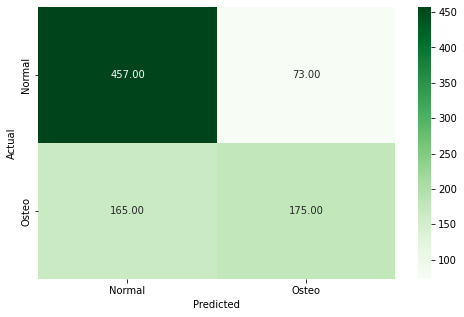

{'0.0': {'precision': 0.7347266881028939,
  'recall': 0.8622641509433963,
  'f1-score': 0.7934027777777778,
  'support': 530},
 '1.0': {'precision': 0.7056451612903226,
  'recall': 0.5147058823529411,
  'f1-score': 0.5952380952380952,
  'support': 340},
 'accuracy': 0.7264367816091954,
 'macro avg': {'precision': 0.7201859246966082,
  'recall': 0.6884850166481686,
  'f1-score': 0.6943204365079365,
  'support': 870},
 'weighted avg': {'precision': 0.7233614937163717,
  'recall': 0.7264367816091954,
  'f1-score': 0.7159591087392811,
  'support': 870}}

In [28]:
metrics_score(y_test, y_pred)

Now we repeat the process with the addition of a categorical features like gender to see it improves anything.

In [29]:
gender = pd.DataFrame(full_df['RIAGENDR'].reset_index(drop=True))
gender

,RIAGENDR
0,1.0
1,2.0
2,1.0
3,2.0
4,2.0
...,...
2892,2.0
2893,1.0
2894,1.0
2895,1.0


In [30]:
new_scaler = StandardScaler()

gender_scaled = pd.DataFrame(new_scaler.fit_transform(gender))

In [31]:
X = pd.concat([pca_result_df_list[3], gender_scaled], axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,0
0,18.330690,-3.604139,-7.604361,0.090369,1.048335,2.074999,2.436813,-5.664631,-4.193139,3.427150,...,-1.932649,0.754784,1.441342,-0.858779,3.650678,0.512048,-0.386451,-0.514563,0.081894,-1.008667
1,-3.641221,-4.594519,0.736721,3.845942,5.325299,1.771576,-1.222113,-2.193195,-1.851584,-0.973812,...,-0.170597,0.549421,-2.550722,-0.384836,-2.091030,0.812368,2.079159,1.006274,1.466778,0.991407
2,0.081501,4.528892,-3.713134,2.723486,0.806007,1.836353,2.666854,-1.446876,-1.449991,-0.941021,...,0.214532,-1.138663,1.881605,-0.523261,-0.355473,0.027940,0.604157,0.587872,-0.846940,-1.008667
3,2.172412,-2.204046,0.828402,6.788101,3.263007,-0.989793,0.457129,2.894954,2.214686,-0.129455,...,0.650737,0.918886,-0.298843,0.081503,0.391764,-1.106691,-0.063714,-0.469542,-0.485635,0.991407
4,-5.398395,-4.213638,-1.590897,-0.050446,-2.845771,3.596250,0.792037,0.483035,-3.264966,2.084432,...,0.559624,1.596810,0.100304,0.519960,-0.662417,-0.851275,0.205546,-1.507765,-0.156457,0.991407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,-3.030840,-1.250503,-2.365265,0.338169,-2.147392,0.011395,-0.618147,-0.730097,0.496354,1.929929,...,0.146175,1.628009,-0.108437,0.192145,-0.457686,0.448107,-1.065477,0.035420,0.571895,0.991407
2893,0.929363,-0.917702,4.166536,-0.630719,4.921542,-2.867036,-3.175363,3.598093,-5.734822,-0.646322,...,-0.100433,-0.378713,0.228391,-0.258741,-0.098038,0.205002,0.200853,-0.716018,-1.195922,-1.008667
2894,1.775568,4.340705,-1.907063,-1.541913,0.278805,0.640501,-0.120412,1.386355,1.557679,-0.176801,...,0.909810,0.680655,-0.905044,-0.254140,-0.156568,-0.028419,0.118171,-0.652137,0.271282,-1.008667
2895,-1.079427,1.061339,0.155231,-2.138689,-0.325118,-0.953752,-0.206752,0.770928,-0.011496,-0.769257,...,-0.104845,-0.352094,0.231369,-0.076481,0.158386,0.194836,-0.245459,-0.536988,-1.425613,-1.008667


In [32]:
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, target, test_size=0.3, random_state=42)

# Create a logistic regression model
logistic2 = LogisticRegression(random_state=42)

# Create the grid search with cross-validation
grid_search2 = GridSearchCV(estimator=logistic2, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the training data
grid_search2.fit(X_train2, y_train2)

# Get the best hyperparameters
best_params2 = grid_search2.best_params_
print(best_params2)

# Create a logistic regression model with the best hyperparameters
best_logistic2 = LogisticRegression(**best_params2)

# Fit the best model to the training data
best_logistic2.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred2 = best_logistic2.predict(X_test2)

{'C': 0.001, 'max_iter': 100, 'solver': 'lbfgs'}


              precision    recall  f1-score   support

         0.0       0.74      0.86      0.79       530
         1.0       0.71      0.52      0.60       340

    accuracy                           0.73       870
   macro avg       0.72      0.69      0.70       870
weighted avg       0.72      0.73      0.72       870



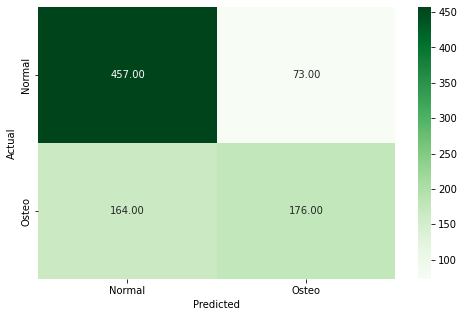

{'0.0': {'precision': 0.7359098228663447,
  'recall': 0.8622641509433963,
  'f1-score': 0.794092093831451,
  'support': 530},
 '1.0': {'precision': 0.7068273092369478,
  'recall': 0.5176470588235295,
  'f1-score': 0.5976230899830222,
  'support': 340},
 'accuracy': 0.7275862068965517,
 'macro avg': {'precision': 0.7213685660516462,
  'recall': 0.6899556048834629,
  'f1-score': 0.6958575919072365,
  'support': 870},
 'weighted avg': {'precision': 0.72454424282727,
  'recall': 0.7275862068965517,
  'f1-score': 0.7173111038217201,
  'support': 870}}

In [33]:
metrics_score(y_test2, y_pred2)

## Pipelines (Not finished)

In [34]:
# Define the pipeline with all custom transformers and standard steps
#full_pipeline = Pipeline([
#    ('feature_selector', FeatureSelector(threshold_unique_values=10)),  # Select relevant features
#    ('data_cleaner', DataCleaner(threshold=10, fill_method=2)),          # Apply data cleaning
#    ('extractor', ExtractTargetFeatures()),                              # Extract target and features
#    ('scaler', StandardScaler()),                                        # Standardize the data
#    ('pca', PCA(n_components=10)),                                       # Perform PCA with 10 components
#    ('classifier', RandomForestClassifier(random_state=42))             # RandomForest classifier
#])
#
## Train the full pipeline on your data
#full_pipeline.fit(X_train, y_train)"""

In [35]:
#data_prep_for_pca_pipeline = Pipeline([
#    ('feature_selector', NumericCategoricalFeaturesCleaner(threshold_unique_values=10)),    # Select relevant features
#    ('data_cleaner', DataCleaner(threshold=10, fill_method=2)),                             # Apply data cleaning
#    ('extractor', ExtractTargetFeatures()),                                                 # Extract target and features
#    ('scaler', StandardScaler()),                                                           # Standardize the data
#])
#
## Train the full pipeline on your data
#data_prep_for_pca_pipeline.fit(numeric_df)"""